In [59]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from process_real import *

In [19]:
SEQUENCE_LENGTH = 15
OVERLAPPING = True
INTERPOLATE = True

# Step 1: Load Data
data, labels = get_all_windows_raw(SEQUENCE_LENGTH, overlapping=OVERLAPPING, interpolate=INTERPOLATE)
data = np.swapaxes(data, 1, 2)

print(f"data.shape: {data.shape}")
print(f"labels.shape: {labels.shape}")
print(f"Positive Cases: {np.count_nonzero(labels)}")
print(f"Negative Cases: {labels.shape[0] - np.count_nonzero(labels)}")

# Removing some set of consecutive positive windows from the data to put into testing
diffs = np.diff(labels)
breaks = np.where(diffs != 0)[0] + 1
sequences = np.split(data, breaks)
seq_label = np.split(labels, breaks)
pos_seq = []
neg_seq = []
pos_lab_seq = []
neg_lab_seq = []
for i, seq in enumerate(seq_label):
  if seq[0] == 1:
    pos_seq.append(sequences[i])
    pos_lab_seq.append(seq)
  else:
    neg_seq.append(sequences[i])
    neg_lab_seq.append(seq)
print(f"break locations: {breaks}")
print(f"num pos seq: {len(pos_seq)}")
seqs_to_withhold = [0, 1]
withheld_data = []
withheld_labels = []
for seq_num in seqs_to_withhold:
  withheld_data.append(pos_seq[seq_num])
  withheld_labels.append(pos_lab_seq[seq_num])

pos_seq = [x for i, x in enumerate(pos_seq) if i not in seqs_to_withhold]
pos_lab_seq = [x for i, x in enumerate(pos_lab_seq) if i not in seqs_to_withhold]

withheld_data = np.concatenate(withheld_data, axis=0)
withheld_labels = np.concatenate(withheld_labels, axis=0)

print(withheld_data.shape)

non_withheld_data = np.concatenate(pos_seq + neg_seq, axis=0)
non_withheld_labels = np.concatenate(pos_lab_seq + neg_lab_seq, axis=0)

data = non_withheld_data
labels = non_withheld_labels

print('data loaded')
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)
print('data split')

# Add witheld data to test
X_test = np.concatenate((X_test, withheld_data), axis=0)
y_test = np.concatenate((y_test, withheld_labels), axis=0)

print(X_test.shape)
print(y_test.shape)
print(X_train.shape)
print(y_train.shape)

# Compute class weights
class_counts = np.bincount(y_train.astype(int))
class_weights = 1. / class_counts
weights = class_weights[y_train.astype(int)]

# Create sampler
sampler = WeightedRandomSampler(weights, len(weights), replacement=True)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

data.shape: (31017, 15, 21)
labels.shape: (31017,)
Positive Cases: 299
Negative Cases: 30718
break locations: [ 2006  2041  2047  2097  2103  2141  2312  2417 17750 17790 17953 17984]
num pos seq: 6
(85, 15, 21)
data loaded
data split
(6272, 15, 21)
(6272,)
(24745, 15, 21)
(24745,)


In [20]:
# Step 2: Create PyTorch Dataset and DataLoader
class SensorDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = SensorDataset(X_train, y_train)
test_dataset = SensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print('datasets initialized')

datasets initialized


In [21]:
# Step 5: Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])
        if (not self.training):
            out = self.sigmoid(out)
        return out

input_size = X_train.shape[2]
hidden_size = 25
output_size = 1
num_layers = 2
dropout = 0

model = LSTMModel(input_size, hidden_size, output_size, num_layers, dropout)
print(model)

LSTMModel(
  (lstm): LSTM(21, 25, num_layers=2, batch_first=True)
  (fc): Linear(in_features=25, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [22]:
# Step 6: Define Loss Function and Optimizer
pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight]))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [23]:
# Step 7: Train the Model
print('training starting')
epochs = 5
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output.squeeze(1), y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}")


training starting
Epoch 1/5, Loss: 3.8800
Epoch 2/5, Loss: 0.2276
Epoch 3/5, Loss: 0.0909
Epoch 4/5, Loss: 0.0246
Epoch 5/5, Loss: 0.0855


In [24]:
# Step 8: Evaluate the Model
model.eval()
test_loss = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        output = model(X_batch)
        loss = criterion(output.squeeze(1), y_batch)
        test_loss += loss.item()
test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 1.8060


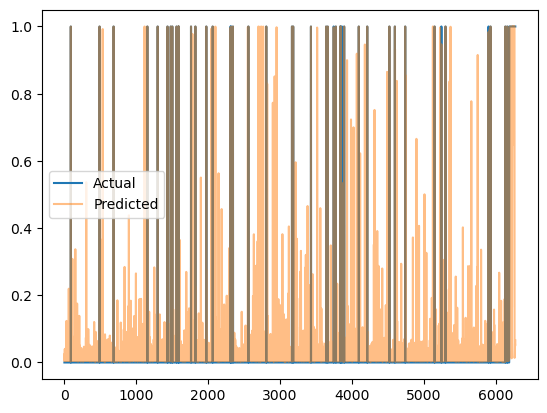

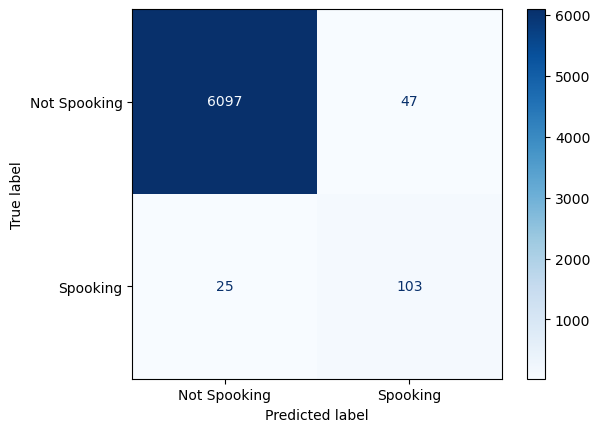

In [ ]:
# Step 9: Visualize Predictions
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        output = model(X_batch).squeeze(1)
        predictions.append(output.numpy().flatten())
        actuals.append(y_batch.numpy().flatten())
actuals = np.concatenate(actuals)
predictions = np.concatenate(predictions)
plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted", alpha=0.5)
plt.legend()
plt.show()

predictions = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch).squeeze(1)
        y_pred_classes = (y_pred >= 0.5).numpy().astype(int)
        predictions.append(y_pred_classes)
        actuals.append(y_batch.numpy())
actuals = np.concatenate(actuals)
predictions = np.concatenate(predictions)

cm = confusion_matrix(actuals, predictions, normalize='true')
disp = ConfusionMatrixDisplay(cm, display_labels=['Not Spooking', 'Spooking'])
disp.plot(cmap="Blues")
plt.show()


(1508,)
(4, 1489)
1


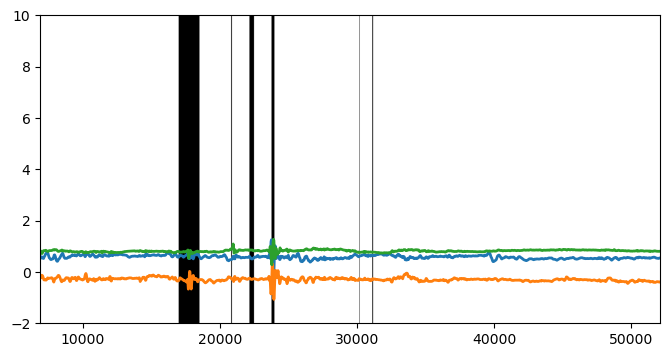

In [597]:
plot_detections(model, 'formatted_data/coy_spooking.csv', SEQUENCE_LENGTH, overlapping=OVERLAPPING, interpolate=INTERPOLATE, threshold=0.99)